### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import dataset
from surprise import Reader
from surprise import KNNWithMeans
from surprise import accuracy

from collections import defaultdict


### Reading the data

In [2]:
raw_data = pd.read_csv("ratings_Electronics.csv", header=None )

# Create copy of original data to work with, so that we can refrence original data in future
df = raw_data.copy()
df.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
# Add column manes to our dataset
df.columns = ['userid', 'productid', 'rating', 'timestamp']

In [4]:
df.head()

,userid,productid,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
df.shape

(7824482, 4)

In [6]:
df.dtypes

userid        object
productid     object
rating       float64
timestamp      int64
dtype: object

In [7]:
# lets check how many unique users and products we have in our dataset
print(df['userid'].nunique())
print(df['productid'].nunique())

4201696
476002


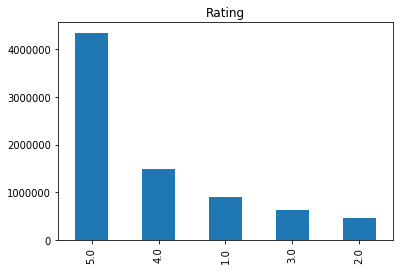

In [8]:
# lets see how product rating is distributed sorted by counts
df['rating'].value_counts().plot.bar( title= 'Rating')


In [9]:
# check if data contains any null values
df.isnull().sum()

userid       0
productid    0
rating       0
timestamp    0
dtype: int64

In [10]:
df_groupby = df.groupby('userid')

In [11]:
df_userid_count = df_groupby.count()

In [12]:
df_userid_count.head()

,productid,rating,timestamp
userid,,,
A00000262KYZUE4J55XGL,1,1,1
A000063614T1OE0BUSKUT,2,2,2
A00009182QVLSWIGHLS1B,1,1,1
A00009661LC9LQPGKJ24G,1,1,1
A00010809P09NUU6ZP6H,1,1,1


In [13]:
# Filter user who has given more then 50 ratings
user_filter =  df_userid_count[df_userid_count['rating'] > 50]

In [14]:
user_filter.shape

(1466, 3)

In [15]:
merged_inner = pd.merge(left=user_filter, right=df, left_on='userid', right_on='userid')

In [16]:
merged_inner.shape

(122171, 7)

In [17]:
merged_inner.head()

,userid,productid_x,rating_x,timestamp_x,productid_y,rating_y,timestamp_y
0,A100UD67AHFODS,116,116,116,B00004Z5M1,5.0,1350086400
1,A100UD67AHFODS,116,116,116,B00005T3X7,5.0,1354665600
2,A100UD67AHFODS,116,116,116,B000069EUW,5.0,1351814400
3,A100UD67AHFODS,116,116,116,B000069JWX,1.0,1070841600
4,A100UD67AHFODS,116,116,116,B0000AR0I4,5.0,1353369600


In [18]:
# only 1,466 users among 42,01,696 rated more then 50 items. 
# we have 1,22,171 records out of  78,24,482 if we only consider such users for our analysis.

In [19]:
df_filtered = merged_inner.iloc[:, [0,4,5]]

In [20]:
df_filtered.columns = ['userid', 'productid','rating']

In [21]:
df_filtered.head()

,userid,productid,rating
0,A100UD67AHFODS,B00004Z5M1,5.0
1,A100UD67AHFODS,B00005T3X7,5.0
2,A100UD67AHFODS,B000069EUW,5.0
3,A100UD67AHFODS,B000069JWX,1.0
4,A100UD67AHFODS,B0000AR0I4,5.0


### Split the data randomly into train and test dataset

In [22]:
# Since we have data in pandas dataframe and we will Surprise to do Collbotative Filtering we convert pandas dataframe 
# to surprise Data object.

In [23]:
reader = Reader(line_format='user item rating', rating_scale=(1, 5))

In [24]:
class MyDataset(dataset.DatasetAutoFolds):

    def __init__(self, df, reader):

        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['userid'], df['productid'], df['rating'])]
        self.reader=reader

In [25]:
data = MyDataset(df_filtered, reader)


In [26]:
trainset, testset = train_test_split(data, test_size=.3)

### Lets build Popularity Recommender model for our Products to find out most popular products

In [27]:
df_filtered.groupby('productid')['rating'].mean().sort_values(ascending=False).head()

productid
B00LKG1MC8    5.0
B000H8WLKC    5.0
B000HA4EZK    5.0
B004EHZZDW    5.0
B004EI0EG4    5.0
Name: rating, dtype: float64

In [28]:
df_filtered.groupby('productid')['rating'].count().sort_values(ascending=False).head()

productid
B0088CJT4U    204
B003ES5ZUU    177
B000N99BBC    163
B007WTAJTO    156
B00829TIEK    146
Name: rating, dtype: int64

In [29]:
ratings_mean_count = pd.DataFrame(df_filtered.groupby('productid')['rating'].mean()) 

In [30]:
ratings_mean_count['rating_counts'] = pd.DataFrame(df_filtered.groupby('productid')['rating'].count())  

In [31]:
ratings_mean_count.head() 

,rating,rating_counts
productid,,
0594481813,3.0,1
0970407998,2.5,2
0972683275,5.0,3
1400501466,3.0,5
1400501520,5.0,1


In [32]:
# Lets only consider a product if it has more then 10 ratings by users to be considered as most popular product.

In [33]:
pop_product = ratings_mean_count[ratings_mean_count['rating_counts'] > 10]

In [34]:
pop_product.sort_values(by=['rating'] , ascending=False).head(10)

,rating,rating_counts
productid,,
B00L3YHF6O,5.0,14
B000FQ2JLW,5.0,18
B0044YPN0A,5.0,11
B000VDCT3C,5.0,14
B0058G40O8,5.0,12
B00HG1L334,5.0,16
B005LDLP8W,5.0,15
B003DZJQQI,5.0,13
B000IJY8DS,5.0,17


In [35]:
# From above dataframe we can see which are the most popular product ID's and how many users rated them.

### Lets build user-user Collaborative Filtering model to make recommendation to our users.

In [36]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [37]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [38]:
test_pred

[Prediction(uid='A27AF4DLLOBQDQ', iid='B009NSMS78', r_ui=4.0, est=4.342105263157895, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AJL3U764D7NI3', iid='B0065SKNNK', r_ui=5.0, est=4.261228498930063, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1B4MIXYVIKMU2', iid='B00AAVF14E', r_ui=5.0, est=4.24, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2UEB48LAWFUCW', iid='B005JXADSW', r_ui=3.0, est=4.386016451233842, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2I2KPNJDQ9SL0', iid='B002YKFTVO', r_ui=5.0, est=4.261228498930063, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AVFJ327UXPXLF', iid='B00DCM91WQ', r_ui=4.0, est=4.86066398390342, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A3H4S6YO9VNGDZ', iid='B00D1IUBAC', r_ui=4.0, est=4.261228498930063, details={'was_impossible': True, 'reason': 'User and/or item is u

### Lets calculate the (RMSE) on predictions.

In [39]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.0572


1.0572417516535397

### Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products.

#### Define a function to filterout top N item prediction for each user.

In [40]:
def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

### Summary 

#### Get top 5 products recommendation for each user.

In [41]:
top_5_recommendation = get_top_n(test_pred, n=5)

for uid, user_ratings in top_5_recommendation.items():
    print(uid, [iid for (iid, _) in user_ratings])

A27AF4DLLOBQDQ ['B009SYZ8OC', 'B003ES5ZUU', 'B009NSMS78', 'B00168Q248', 'B008KEPX1O']
AJL3U764D7NI3 ['B00AYQ433U', 'B007PLL4CK', 'B00B7I8HZ4', 'B0028Y4FVQ', 'B004K1EZDS']
A1B4MIXYVIKMU2 ['B00IF4OATU', 'B001RB24PK', 'B004X69BFW', 'B0010TZR44', 'B009AOFKUM']
A2UEB48LAWFUCW ['B00EU9V3YO', 'B005HMKKH4', 'B001L1H0SC', 'B00IVPU59W', 'B003G2Z1M6']
A2I2KPNJDQ9SL0 ['B003ES5ZUU', 'B007SM7O2U', 'B00434OWDA', 'B00A83I8G2', 'B003IE49T8']
AVFJ327UXPXLF ['B0036VO6IC', 'B00BOHNYU6', 'B00DCM91WQ', 'B0035FZ124', 'B000O8WE66']
A3H4S6YO9VNGDZ ['B008UGPBXM', 'B008JJLW4M', 'B00BQ4F9ZA', 'B0019EQ1RW', 'B000068O16']
A149RNR5RH19YY ['B001F51G16', 'B00003006E', 'B000TII90G', 'B00008RW8L', 'B0001DHHI4']
A2L9OPJAAEK08Q ['B009F7IBZK', 'B000089GN4', 'B000HFQNWC', 'B001GS8G1A', 'B004Q2Y6GM']
A3N4VTNFPMTHEF ['B0058NN6CS', 'B001NTFAOS', 'B003VAK1G4', 'B007PJ4Q4A', 'B000UEZ36W']
A3SL0HA6422W4M ['B005KJJKVG', 'B00B6QXWIY', 'B00A3U7IS4', 'B0067Z6BNC', 'B008MB70TI']
A38C12950IM24P ['B00DK2JQOQ', 'B00I0G8GNY', 'B00H8O8CMO'

AGATRDOFW48DK ['B000IMWEHM', 'B000HZM1YG', 'B004THTTW0', 'B00066FIO6', 'B000IMYAVU']
ADHA1W879JNT0 ['B00005QFZF', 'B0097NPQ8W', 'B00006B7H9', 'B00AE256BW', 'B001MSTA0A']
A20UU20K7M9ZPF ['B004ZBMYS6', 'B0056EXUBQ', 'B004EKEF0S', 'B0057UKLJ8', 'B005ZEEWS2']
A30R8VFR16RE32 ['B003ES5ZUU', 'B00EZ9XKA4', 'B008DWGLLO', 'B003FMUP0K', 'B002M03KVC']
A31HE83MU98GBV ['B00J4O573S', 'B004DI7CW4', 'B000S6PENO', 'B0015DYMVO', 'B005GOINEK']
AOMEH9W6LHC4S ['B006A93M7I', 'B008MDSWI4', 'B00DX64DBU', 'B002VPE1YS', 'B004CLYEDC']
A1B0NL8UWAELI7 ['B001AG9T1Y', 'B002OOWC3S', 'B001GX6MJ8', 'B005LJKEXS', 'B0053G6G54']
A15U64VGUV6RBF ['B000BKJZ9Q', 'B003ES5ZUU', 'B001F7AHOG', 'B0052SCU8U', 'B003ES5ZR8']
A356RFKNIG043B ['B000SY1PQ6', 'B00KK90R1I', 'B00006LK1O', 'B0082E9K7U', 'B007JCMDA2']
A267FU71Z01CIH ['B00DT04I9W', 'B00BWL33H8', 'B0079R8KO0', 'B0079UAT0A', 'B00G6CLN3Y']
AUUV3XDYB16X5 ['B000VS4HDM', 'B003QSG0HK', 'B004H9C4JK', 'B00AWKC0JM', 'B00006I5SI']
A3J2YU2D9BH2J7 ['B001TH7GUA', 'B001MSU1HG', 'B00A35WYBA', 

#### The most popular prodcts are B00L3YHF6O, B000FQ2JLW, B0044YPN0A, B000VDCT3C, B0058G40O8. We can recomend these products to New users, Grey sheep users or to users on which we dont have enough information